RUN SBI-SGM in all bands

parameters order is  :taue,taui,tauG,speed,alpha,gii,gei (In second)

## Import some pkgs

In [1]:
import sys
sys.path.append("../mypkg")

import scipy
import itertools

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict

In [2]:
# SBI and torch
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import analysis
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as sutils

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [3]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch

## Some fns

In [4]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

In [5]:
# transfer vec to a sym mat
def vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

In [6]:
def get_mode(x):
    kde_est = scipy.stats.gaussian_kde(x)
    xs = np.linspace(x.min(), x.max(), 500)
    ys = kde_est(xs)
    return xs[np.argmax(ys)]

### Some parameters

In [7]:
_paras = edict()
_paras.delta = [2, 3.5]
_paras.theta = [4, 7]
_paras.alpha = [8, 12]
_paras.beta = [13, 20]
_paras.beta_l = [13, 20]

In [8]:
# Parameter bounds for optimization
v_lower = 3.5-1.8
v_upper = 3.5+1.8
bnds = ((0.005,0.030), (0.005,0.2), (0.005,0.030), (v_lower,v_upper), (0.1,1.0), (0.5,10.0), (0.5,10.0))
#taue,taui,tauG,speed,alpha,gii,gei

In [9]:
paras = edict()

paras.fc_types = ["delta", "theta", "alpha", "beta_l"]
paras.freqranges =  [np.linspace(_paras[fc_type][0], _paras[fc_type][1], 5) 
                     for fc_type in paras.fc_types]
print(paras.freqranges)
paras.fs = 600
paras.num_nodes = 86 # Number of cortical (68) + subcortical nodes
paras.par_low =  np.array([ix[0] for ix in bnds])
paras.par_high = np.array([ix[1] for ix in bnds])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.prior_sd = 10
paras.add_v = 0.05

paras.SBI_paras = edict()
paras.SBI_paras.num_prior_sps = int(1e4)
paras.SBI_paras.density_model = "nsf"
paras.SBI_paras.num_round = 2
paras.SBI_paras.noise_sd = 0.2

[array([2.   , 2.375, 2.75 , 3.125, 3.5  ]), array([4.  , 4.75, 5.5 , 6.25, 7.  ]), array([ 8.,  9., 10., 11., 12.]), array([13.  , 14.75, 16.5 , 18.25, 20.  ])]


In [10]:
# fn for reparemetering
_map_fn_torch = partial(logistic_torch, k=0.1)
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=0.1))

### Load the data

In [11]:
# SC
ind_conn_xr = xr.open_dataarray('../data/individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

# PSD
ind_psd_xr = xr.open_dataarray('../data/individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
fvec = ind_psd_xr["frequencies"].values

def _add_v2con(cur_ind_conn):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.max(cur_ind_conn)*paras.add_v # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], cur_ind_conn[:34, 34:68] + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], cur_ind_conn[34:68, :34] + add_v)
    np.fill_diagonal(cur_ind_conn[68:77, 77:], cur_ind_conn[68:77, 77:] + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], cur_ind_conn[77:, 68:77] + add_v)
    return cur_ind_conn

if paras.add_v != 0:
    print(f"Add {paras.add_v} on diag")
    ind_conn_adds = [_add_v2con(ind_conn[:, :, ix]) for ix in range(36)]
    ind_conn = np.transpose(np.array(ind_conn_adds), (1, 2, 0))
ind_conn_cohort = ind_conn.mean(axis=-1)

Add 0.05 on diag


In [12]:
# Load true MEG FC time series:
true_FCs_cohort = []
for fc_type in paras.fc_types:
    dataPath = DATA_ROOT/f'./MEG_FC_{fc_type}_DK_networks_coh.mat'
    data = loadmat(dataPath);
    true_FC = data[f"MEG_{fc_type}_FC_networks_coh"]
    true_FC_cohort = true_FC.mean(axis=-1)
    true_FCs_cohort.append(true_FC_cohort)

true_FCs_cohort[0].shape

(68, 68)

In [21]:
true_FC.min()

0.0

## SBI

### Prior

In [13]:
prior = MultivariateNormal(loc=torch.zeros(7), covariance_matrix=torch.eye(7)*(paras.prior_sd**2))

In [14]:
def simulator(raw_params, brain, noise_sd, prior_bds, freqranges):
    params = []
    for raw_param, prior_bd in zip(raw_params, prior_bds):
        param =  _map_fn_torch(raw_param)*(prior_bd[1]-prior_bd[0]) + prior_bd[0]
        params.append(param)
    params = torch.tensor(params)
    
    params_dict = dict()
    params_dict["tau_e"] =  params[0].item()
    params_dict["tau_i"] =  params[1].item()
    params_dict["tauC"] =  params[2].item()
    params_dict["speed"] =  params[3].item()
    params_dict["alpha"] =  params[4].item()
    params_dict["gii"] =  params[5].item()
    params_dict["gei"] =  params[6].item()
    ress = []
    for freqrange in freqranges:
        modelFC = build_fc_freq_m(brain , params_dict, freqrange)
        modelFC_abs = np.abs(modelFC[:68, :68])
        res = _minmax_vec(modelFC_abs[np.triu_indices(68, k = 1)])
        ress.append(res)
    ress = np.concatenate(ress)
    noise =  np.random.randn(*ress.shape)*noise_sd
    return (ress+ noise).flatten()
    

In [15]:
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT) # grabs distance matrix
# re-ordering for DK atlas and normalizing the connectomes:
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.connectome =  ind_conn_cohort
brain.bi_symmetric_c()
brain.reduce_extreme_dir()
    
simulator_sp = partial(simulator, brain=brain, 
                           noise_sd=paras.SBI_paras.noise_sd, 
                           prior_bds=paras.prior_bds, freqranges=paras.freqranges)
simulator_wrapper, prior = prepare_for_sbi(simulator_sp, prior)
inference = SNPE(prior=prior, density_estimator=paras.SBI_paras.density_model)
proposal = prior 
    
#the observed data
res_vecs = []
for true_FC_cohort in true_FCs_cohort:
    cur_obs_FC = np.abs(true_FC_cohort)
    res_vec = _minmax_vec(cur_obs_FC[np.triu_indices(68, k = 1)])
    res_vecs.append(res_vec)
res_vecs = np.concatenate(res_vecs)
curX = torch.Tensor(res_vecs)
num_spss = [10000, 1000, 1000]
for ix in range(paras.SBI_paras.num_round):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal,
                                    num_simulations=num_spss[ix],
                                    #num_simulations=paras.SBI_paras.num_prior_sps, 
                                    num_workers=20)
    density_estimator = inference.append_simulations(
                            theta, x, proposal=proposal
                            ).train()
    posterior = inference.build_posterior(density_estimator)
        
        
    #update proposal 
    proposal = posterior.set_default_x(curX)
    
#MR: multi-round
save_fil = f"posteriorMRmulDiffNum_{'-'.join(paras.fc_types)}_" + \
           f"num{paras.SBI_paras.num_prior_sps}_" + \
           f"density{paras.SBI_paras.density_model}_" + \
           f"MR{paras.SBI_paras.num_round}_" + \
           f"noise_sd{paras.SBI_paras.noise_sd*100:.0f}_" +\
           f"addv{paras.add_v*100:.0f}_" +\
           f"ind_cohort.pkl"
        
save_pkl(RES_ROOT/save_fil, proposal)

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 23 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/hujin/.local/lib/python3.9/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  outputs, _ = torch.triangular_solve(


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC1/SBI-SGM-FC/notebooks/../mypkg/../results/posteriorMRmulDiffNum_delta-theta-alpha-beta_l_num10000_densitynsf_MR2_noise_sd20_addv5_ind_cohort.pkl


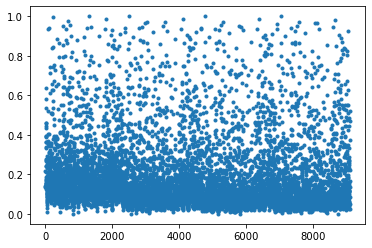

In [20]:
plt.plot(res_vecs, ".")